# DSCI 512 Lecture 5


In [1]:
import numpy as np
import networkx as nx  # pip install networkx
from collections import Counter

Outline:

- Graphs intro (5 min)
- Graph types (5 min)
- Stacks and queues (5 min)
- Graph searches: recursive implementation (25 min)
- Break (5 min)
- Graph searches: iterative implementation (10 min)
- Centrality, PageRank (10 min)
- Other graph properties (5 min)
- True/False questions (25 min) ?

## Graphs intro (5 min)

Trees allowed us to represent hierarchical relationships. However, many relationships are not hierarchical:

- friendships (on Facebook, Twitter, or in real life)
- connections between machines on the internet
- direct flight connections between airports
- etc.

A graph consists of: 

- A set of _vertices_ or _nodes_
- A set of pairs of vertices, called _edges_

In [2]:
G = nx.Graph()

G.add_node("A")
G.add_node("B")
G.add_node("C")
G.add_node("D")
G.add_node("E")

G.add_edge("A", "B")
G.add_edge("B", "C")
G.add_edge("C", "D")
G.add_edge("D", "E")
G.add_edge("E", "A")
G.add_edge("A", "C")
G.add_edge("B", "D")
G.add_edge("C", "E")

- The graph package we're using, `networkx`, randomly visalizes the graph each time.
    - By re-running the next cell, we can see a few equivalent representations.
    - They are all the same graph!
    - See [`networkx.draw` documentation](https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html).

In [3]:
# The defaults are hard to see on a projector in class
draw_params = {"node_color" : "pink", "font_size" : 20, "with_labels" : True, "arrowsize" : 30}

In [4]:
nx.draw(G, **draw_params)

Note: we can set the random seed if we want a fixed drawing:

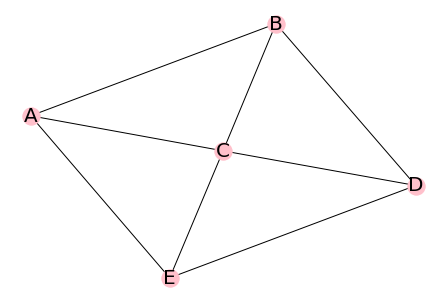

In [5]:
nx.draw(G, **draw_params, pos=nx.spring_layout(G, seed=5))

(Jupyter note: I had to specify "Disable Scrolling for Outputs" to make this look nicer.)

Some graph terminology:

- The _degree_ of a vertex is the number of edges connected to it.
  - Above, "B" has degree 3 and "C" has degree 4.
- A graph is _complete_ if every pair of vertices is joined by an edge.
  - The graph above is not complete because "B" and "E" are not directly connected (same with "A" and "D").
  - Below is an example of a complete graph with 4 vertices.

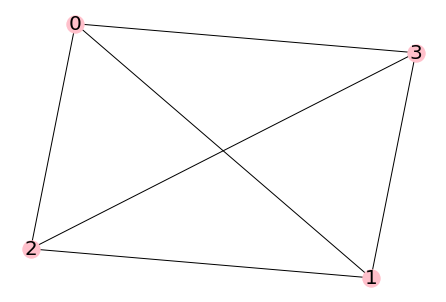

In [6]:
complete = nx.complete_graph(4)

nx.draw(complete, **draw_params)

- Above, we are representing the graphs by edge lists or adjacency lists.
- Next lecture we'll talk about another representation, adjacency matrices.


More terminology:

- A graph is _connected_ if there is exists a path between any pair of nodes.
  - Below is an example disconnected graph. 

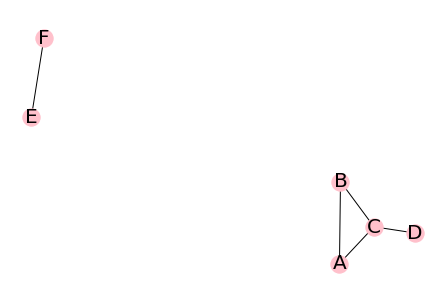

In [7]:
disconnected = nx.Graph()

disconnected.add_node("A")
disconnected.add_node("B")
disconnected.add_node("C")
disconnected.add_node("D")
disconnected.add_node("E")
disconnected.add_node("F")

disconnected.add_edge("A", "B")
disconnected.add_edge("A", "C")
disconnected.add_edge("D", "C")
disconnected.add_edge("B", "C")

disconnected.add_edge("E", "F")

nx.draw(disconnected, **draw_params)

## Graph types (5 min)

#### Undirected graphs

- This is what we've been looking at so far.
- Saying "there is an edge from A to B" is the same as saying "there is an edge from B to A"
- You can try this out in `networkx`.

#### Directed graphs

- Sometimes, relationships are directed (e.g. Twitter).
- This gives us a directed graph. We typically draw the direction with an arrow.
- Example:


In [8]:
G = nx.DiGraph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("B", "C")
G.add_edge("A", "C")

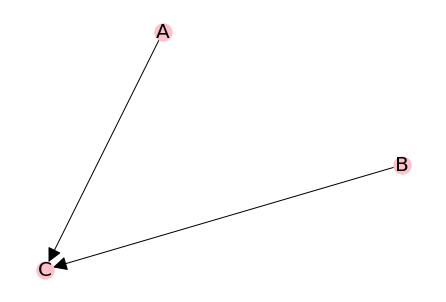

In [9]:
nx.draw(G, **draw_params)

Now let's reverse the direction of the edge from "B" to "C":

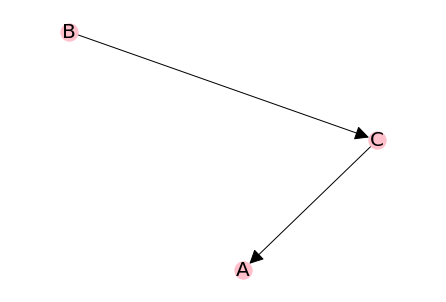

In [10]:
G = nx.DiGraph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("B", "C")
G.add_edge("C", "A")

nx.draw(G, **draw_params)

- This is a fundamentally different graph. 
- The choice of graph type depends on the situation you're modelling. 
  - The MDS prerequisite graph is directed.

![](mds.png)

- Note that this is a directed graph, NOT a tree, because nodes can have multiple parents.

- Directed graphs can also have reciprocal connections:

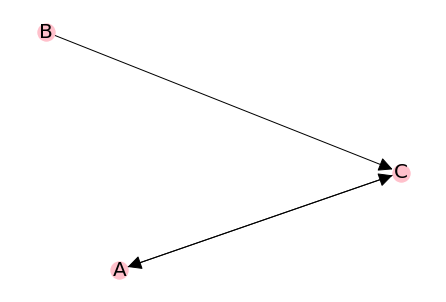

In [11]:
G = nx.DiGraph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("B", "C")

# add a 2-way edge
G.add_edge("C", "A")
G.add_edge("A", "C")

nx.draw(G, **draw_params)

- Here, we have a double-headed arrow between A and C. 
- In an undirected graph, it wouldn't have made sense to have both 

```python
G.add_edge("C", "A")
G.add_edge("A", "C")
```

because one would be sufficient.

- Directed graphs also can have self-connections.
  - `networkx` supports them but it doesn't draw them properly.
  - You will see these when getting to Markov chains in DSCI 575.

#### Unweighted graphs

All the graphs above are "unweighted" because all edges are equal.

#### Weighted graphs

Both undirected and directed graphs can have weighted edges.

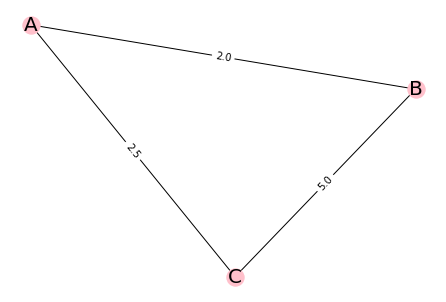

In [12]:
G = nx.Graph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("A", "B", weight=2.0)
G.add_edge("B", "C", weight=5.0)
G.add_edge("C", "A", weight=2.5)

pos = nx.spring_layout(G)
nx.draw(G, pos, **draw_params)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels);

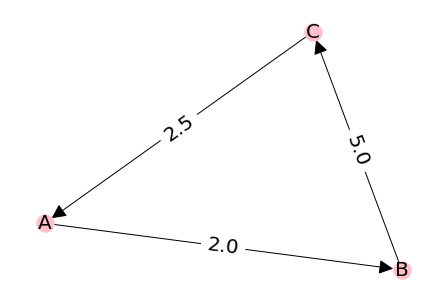

In [13]:
G = nx.DiGraph()

G.add_node("A")
G.add_node("B")
G.add_node("C")

G.add_edge("A", "B", weight=2.0)
G.add_edge("B", "C", weight=5.0)
G.add_edge("C", "A", weight=2.5)

pos = nx.spring_layout(G)
nx.draw(G, pos, **draw_params)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=20);

Examples where graphs can be used to model a situation:

- Flights between airports: weights can be cost or flight time between destinations.
  - Now we definitely want a directed graph, as the cost/time may depend on the direction.
  - Useful problem: minimum cost path from $A$ to $B$. This is called the [shortest path problem](https://en.wikipedia.org/wiki/Shortest_path_problem).
- Countries.
  - Edge weights could be number of dual citizens (undirected).
  - Or trade/immigration in each direction (directed).
  - The weights could be the trade volume.

## Stacks and queues (5 min)

- Let's briefly discuss some data structures we'll need shortly.
- We want a data structure that we can put things into, and then retrieve them later.
- A [stack](https://en.wikipedia.org/wiki/Stack_(abstract_data_type)) does with with the "last in, first out" (LIFO) mentality - like a stack of books or plates.

In [14]:
class Stack:
    """A stack data structure."""

    def __init__(self):
        self.data = list()

    def push(self, item):
        """
        Adds a new item to the top of the stack.
        
        Parameters
        ----------
        item : object
           An item added to the stack
        """
        self.data.append(item)

    def pop(self):
        """
        Removes the item that is at the top of the stack and returns the item.

        Returns
        -------
        object 
             The item that was last added to the stack.

        Examples
        --------
        >>> stack = Stack()
        >>> stack.push(1)
        >>> stack.push([1, 2, "dog"])
        >>> stack.push("popcorn")
        >>> stack.pop()
        'popcorn'
        """
        return self.data.pop()

    def isEmpty(self):
        """ 
        Checks to see if the stack is empty.

        Returns
        -------
        bool 
             True if the stack contains no items, False otherwise.    

        Example
        --------
        >>> stack = Stack()
        >>> stack.isEmpty()
        True
        """
        return len(self.data) == 0
    
    def __str__(self):
        return self.data.__str__()

In [15]:
s = Stack()

s.push("first")
s.push("second")

print(s)

['first', 'second']


In [16]:
s.pop()

'second'

In [17]:
print(s)

['first']


In [18]:
s.push("third")
s.push("fourth")

In [19]:
print(s)

['first', 'third', 'fourth']


In [20]:
s.pop()

'fourth'

In [21]:
s.pop()

'third'

In [22]:
s.pop()

'first'

In [23]:
s.pop()

IndexError: pop from empty list

- Along with stacks we also have [queues](https://en.wikipedia.org/wiki/Queue_(abstract_data_type)), which use "first in, first out" (FIFO) ordering.
  - e.g. an actual queue/lineup

In [24]:
class Queue:
    """A Queue data structure."""
    
    def __init__(self):
        self.data = list()

    def push(self, item):
        """
        Adds a new item to the end of the queue.
        
        Parameters
        ----------
        item : object
           An item added to the queue
        """
        
        self.data.append(item)

    def pop(self):
        """
        Removes the item that is at the front of the queue and returns the item.

        Returns
        -------
        object 
             The least recent item added to the queue.     

        Example
        --------
        >>> queue = Queue()
        >>> queue.push(1)
        >>> queue.push([1, 2, "dog"])
        >>> queue.push("popcorn")
        >>> queue.pop()
        '1'
        """
        return self.data.pop(0)

    def isEmpty(self):
        """ 
        Checks to see if the queue is empty. 

        Returns
        -------
        bool 
            True if the stack contains no items, False otherwise.    

        Example
        --------
        >>> queue = Queue()
        >>> queue.push(1)
        >>> Queue.isEmpty()
        False
        
        """
        return len(self.data) == 0
    
    def __str__(self):
        return self.data.__str__()

In [25]:
q = Queue()

q.push("first")  # often called "enqueue"
q.push("second")

print(q)

['first', 'second']


In [26]:
q.pop() # often called "dequeue"

'first'

In [27]:
print(q)

['second']


In [28]:
q.push("third")
q.push("fourth")

In [29]:
while not q.isEmpty():
    print(q.pop())

second
third
fourth


## Graph searches: recursive implementation (25 min)

Next, we'll discuss some algorithms performed on graphs.

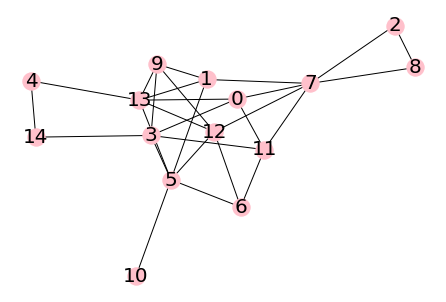

In [30]:
# pappus = nx.pappus_graph()
# nx.draw(pappus, with_labels=True, arrowsize=40)

erg = nx.erdos_renyi_graph(15, 0.2, seed=40)
nx.draw(erg, **draw_params, pos=nx.spring_layout(erg, seed=5))

- Question: are nodes $0$ and $14$ connected?
  - We can see this easily with our eyes.
  - But imagine a dataset with millions of nodes and billions of edges, like a Facebook social network (see lab).
  - We can't "eyeball" if two people are connected; we need an algorithm.

- Approach: visit all neighbours of node $0$, then all neighbours of these neighbours, etc.
  - Keep track of which nodes have already been visited so we don't get stuck in an infinite cycle.

In [31]:
def connected(g, node1, node2, visited=None, verbose=False):
    """ 
    Check whether node1 and node2 are connected in the graph g (using DFS).

    Parameters
    ----------
    g : networkx.classes.graph.Graph
        the graph
    node1 : str, int
        first node
    node2 : str, int
        second node
    visited : set
        contains visited nodes (default is None)
    verbose : bool
        if True, node location will be displayed (default is False)
    
    Returns
    -------
    bool 
        True if the two nodes are connected and False otherwise     

    Example
    --------
    >>> graph = nx.erdos_renyi_graph(2, 1)
    >>> connected(graph, 1, 0)
    True
    """
    if visited is None:
        visited = {node1}  # initialize

    if node1 == node2:
        return True

    # for all the unvisited neighbours of node1
    for v in g.neighbors(node1):
        if v in visited:
            continue

        visited.add(v)

        if verbose:
            print("At node", v)

        # If a connection found, passes the True value all the way up to the top level.
        if connected(g, v, node2, visited, verbose):
            return True

    return False

Let's discuss how the code works:

- We keep track of all nodes that we've visited, so that we don't visit them again.
- Base case: if the start node equals the end node, return True.
- For all *unvisited* the neighbours of the start node:
  - Add to visited set
  - Recursively check if these nodes are connected to the start node
- If you finish the loop and don't find anything, return False.

In [32]:
connected(erg, 0, 14)

True

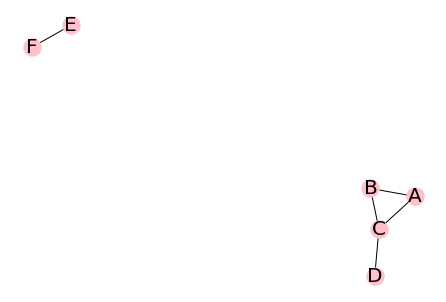

In [33]:
nx.draw(disconnected, **draw_params)

In [34]:
assert connected(disconnected, "A", "B")
assert connected(disconnected, "A", "C")
assert connected(disconnected, "A", "D")
assert connected(disconnected, "B", "C")
assert connected(disconnected, "B", "D")
assert connected(disconnected, "E", "F")
assert not connected(disconnected, "A", "E")
assert not connected(disconnected, "A", "F")
assert not connected(disconnected, "D", "E")
assert not connected(disconnected, "D", "F")
assert not connected(disconnected, "C", "E")

- Question: in what order were the nodes traversed?

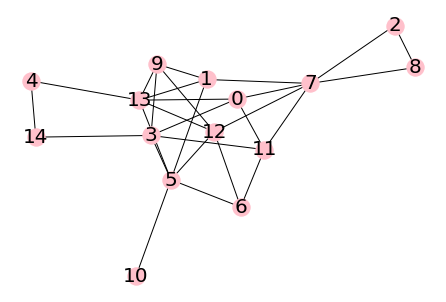

In [35]:
nx.draw(erg, **draw_params, pos=nx.spring_layout(erg, seed=5))

In [36]:
connected(erg, 0, 14, verbose=True)

At node 3
At node 5
At node 1
At node 7
At node 2
At node 8
At node 11
At node 6
At node 12
At node 9
At node 13
At node 4
At node 14


True

- Note the order: 
  - It's taking 0's first neighbour, which is 3
  - Then 3's first neighbour, which is 5
  - Then 5's first neighbour, which is 1
  - This is called [depth first search](https://en.wikipedia.org/wiki/Depth-first_search) (DFS) because we go deep into the graph
  - **To do in class**: draw the recursion tree.
- What if this was a huge graph, and the two nodes were right next to each other?
  - The algorithm might be extremely ineffecient.

## Break (5 min)

## Graph searches: iterative implementation (15 min)

- Implementation:
  - Let's implement it non-recursively this time.
  - Every time we visit a node, we add its neighbours to the queue.
  - This ensures we'll visit the all the "distance 1 neighbours" before visiting any "distance 2 neighbours".

In [37]:
def connected_bfs(g, node1, node2, verbose=False):
    """ 
    Given a NetworkX Graph g, and start node node1 
    and goal node node2, tests whether node1 and node2
    are connected in the graph g using breadth first search.
    If they are not connected, returns False.

    Parameters
    ----------
    g : networkx.classes.graph.Graph
        the graph
    node1 : str, int
        first node
    node2 : str, int
        second node
    verbose : bool
        if True, node location will be displayed while False will not
        (default is False)
    
    Returns
    -------
    bool 
        True if the two nodes are connected and False otherwise     

    Example
    --------
    >>> graph = nx.erdos_renyi_graph(2, 1)
    >>> connected_bfs(graph, 1, 0)
    True
    """
    
    q = Stack()
    q.push(node1)

    visited = set()

    while not q.isEmpty():
        vertex = q.pop()
        if vertex == node2:
            return True

        if vertex in visited:
            continue

        visited.add(vertex)

        if verbose:
            print("At node", vertex)

        for v in g.neighbors(vertex):
            if v not in visited:
                # TODO: no need to add if already in queue?
                q.push(v)

    return False

In [38]:
connected_bfs(erg, 0, 14)

True

In [39]:
connected_bfs(erg, 0, 14, verbose=True)

At node 0
At node 13
At node 12
At node 9
At node 3


True

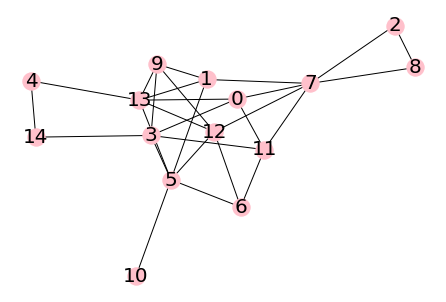

In [40]:
nx.draw(erg, **draw_params, pos=nx.spring_layout(erg, seed=5))

- The beauty is that to turn this into DFS, we only need to change the `Queue` to a `Stack`.
  - (Though there are some minor details here - the neighbours will traversed in reverse order).

Some very similar algorithms can be used to determine the "distance" between nodes:

In [41]:
nx.shortest_path_length(erg, 0, 14)

2

- This means it takes $2$ hops to get from node $0$ to node $14$.
- As an optional question in lab you are asked to implement this, by extending the above code to keep track of the number of steps.

## Centrality, PageRank (10 min)


In [42]:
sfg = nx.scale_free_graph(10, seed=25)

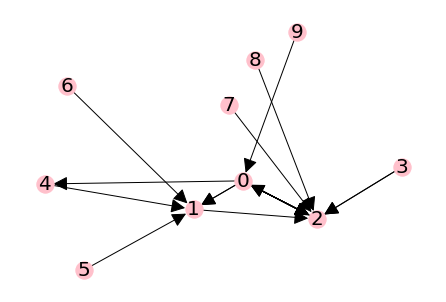

In [43]:
nx.draw(sfg, **draw_params, pos=nx.spring_layout(sfg, seed=25))

- Which is the most "important" webpage here? Perhaps $1$ or $2$? 
- This is a question known as [centrality](https://en.wikipedia.org/wiki/Centrality). 
  - See also the idea of a [hub](https://en.wikipedia.org/wiki/Hub_(network_science)) (not discussed further).
- We'll focus on a particular measure of centrality, [PageRank](https://en.wikipedia.org/wiki/PageRank).
    - This is the algorithm that made Google the best search engine.

- Conceptual model: let websites be nodes in a graph.
  - Put a directed edge from site $A$ to $B$ if site $A$ links to site $B$.
- There is a specific definition of PageRank.
  - The way to find it is mathematically beautiful and is essentially a linear algebra problem.
  - That is beyond the scope here.
- But we can approximate the PageRank with Monte Carlo, with a "simulated web surfer", as follows:
  1. We start at some random node
  2. With probability $\alpha$ choose a completely random node in the graph (this emulates the user going to a random new page); with probability $(1−\alpha)$ choose a random neighbour of the current node (this emulates the user clicking on a link on the page). 
  3. Repeat Step 2 $n$ times.
  4. The ranking of each node is proportional to the number of times this random walk visits the node.
- To repeat, this is **not** how Google computes PageRank; there is a more elegant/efficient way.

In [44]:
def page_rank(G, alpha=0.1, iters=100000):
    """
    Compute the PageRank for all nodes in the directed graph G.
    Returns a dictionary of the PageRank for all nodes.

    Parameters
    ----------
    G : networkx.classes.graph.DiGraph
        the graph
    alpha : float
        the probability of surfing to a random page
    iters : int
        the number of iterations of simulation to perform

    Returns
    -------
    collections.Counter 
        A dictionary containing the PageRank for each node.

    Example
    --------
    >>> pr = page_rank(nx.scale_free_graph(3))
    Counter({2: 33349, 0: 33371, 1: 33280})
    """

    visited = Counter()

    nodes = G.nodes()
    current_node = np.random.choice(nodes)
    for i in range(iters):
        if np.random.random() < alpha:
            current_node = np.random.choice(nodes)
        else:
            current_node = np.random.choice(list(G.neighbors(current_node)))
        visited[current_node] += 1

    return visited

Let's look at the code:

- We start at a random node.
- For each iteration:
- With probability $\alpha$, go to a random node.
- Else (with probability $1-\alpha$) go to a random neighbour.
- Keep score whenever you visit a node.
- That's it!

In [45]:
pr = page_rank(sfg)

In [46]:
pr.most_common()

[(2, 43637),
 (0, 27599),
 (1, 15572),
 (4, 7259),
 (7, 1035),
 (8, 1014),
 (5, 985),
 (3, 978),
 (9, 963),
 (6, 958)]

Here's the graph again, so it's nearby:

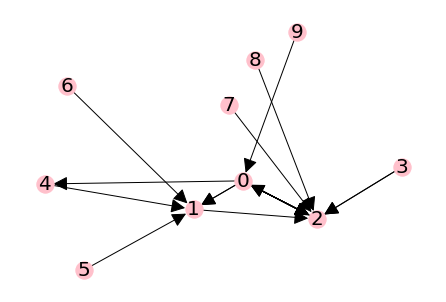

In [47]:
nx.draw(sfg, **draw_params, pos=nx.spring_layout(sfg, seed=25))

- **Question**: node $2$ is first; that makes sense. But why is node $0$ above node $1$? 

<br><br><br><br><br><br><br><br>

- **Answer**: because node $2$ only links there, and node $2$ has a very high PageRank.
- So, a link from a popular page is more valuable than a link from a no-name page. Makes sense!
- We can just sort the pages by number of incoming links, and we see we get a different (worse) ranking:

In [48]:
num_neigh = {i: len(list(nx.reverse_view(sfg).neighbors(i)))
             for i in sfg.nodes()}
for node in sorted(num_neigh, key=num_neigh.get, reverse=True):
    print("Node", node, "has", num_neigh[node], "incoming links")

Node 2 has 6 incoming links
Node 1 has 4 incoming links
Node 0 has 3 incoming links
Node 4 has 1 incoming links
Node 3 has 0 incoming links
Node 5 has 0 incoming links
Node 6 has 0 incoming links
Node 7 has 0 incoming links
Node 8 has 0 incoming links
Node 9 has 0 incoming links


Here, indeed, we get node $1$ above node $0$.

Optional note: there are two sources of "randomness" here:

- The fact that the model is inherently probabilistic (do this with probability $\alpha$)
- The limitations of our simulation (start at one random node, finite number of iterations)

These are very different from each other. You can mathematically find the true PageRank, which solves the second problem. The first one is not a problem though, it is just part of the definition of PageRank.

You may encounter similar concepts to this in the Stat courses.

## Other graph properties (5 min)

There are a lot of standard problems in graph theory, not covered in this course, such as:

- Find the largest [clique](https://en.wikipedia.org/wiki/Clique_(graph_theory)) in a graph.
- Find the largest [independent set](https://en.wikipedia.org/wiki/Independent_set_(graph_theory)) in a graph.
- Find the [vertex cover](https://en.wikipedia.org/wiki/Vertex_cover) of a graph with the smallest number of vertices.
- Find the smallest [dominating set](https://en.wikipedia.org/wiki/Dominating_set) in a graph.
- [Colour](https://en.wikipedia.org/wiki/Graph_coloring) a graph with the smallest number of colours.

It turns out a lot of real-world problems can be mapped to these problems, and thus solving these problems is important. 

- **However**, they are [NP-Complete](https://www.geeksforgeeks.org/np-completeness-set-1/).
  - You may have heard this term.
  - We aren't going into this here due to lack of time.
  - But, in short, we don't have fast algorithms to solve these problems. 

## T/F questions (25 min)


1. To model Twitter relationships, one would naturally use a directed, weighted graph.
2. In an directed graph, if there is a path from $A$ to $B$ then there is a path from $B$ to $A$.
3. The number of edges in a graph must be less than or equal to the number of nodes. 
4. The number of edges in a graph must be more than or equal to the number of nodes.

<br><br><br><br><br><br><br><br>

1. DFS can be naturally implemented with a stack, and BFS with a queue.
1. For the purpose of checking whether two nodes are connected, BFS is always faster than DFS.
1. For some graphs, DFS is equivalent to BFS.
1. The website with the highest PageRank may depend on the parameter $\alpha$.